In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import cv2
import skimage.morphology
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
pgm_list = []
pgm_gt_list =[]
for i in range(1, 21):
    pgm_list.append(cv2.imread(f'database/{i}.pgm', cv2.IMREAD_UNCHANGED))
    pgm_gt_list.append(cv2.imread(f'database/{i}_gt.pgm', cv2.IMREAD_UNCHANGED))

In [3]:
def plot_angiogramas(original_images, modifided_images, i):    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].imshow(original_images[i-1], cmap='gray')
    axes[0].set_title(f'Original {i}')
    axes[0].axis('off')
    axes[1].imshow(modifided_images[i-1], cmap='gray')
    axes[1].set_title(f'Modificada {i}')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
def plot_angiograma(modified_image):    
    plt.figure(figsize=(5, 3))
    plt.imshow(modified_image, cmap='gray')
    plt.title(f'Modificada')
    plt.axis('off')
    plt.show()

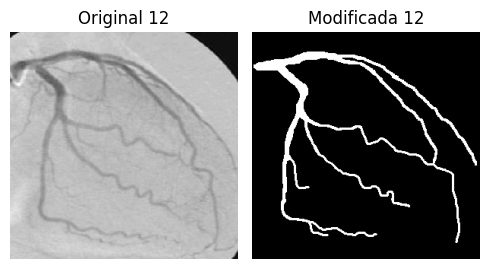

In [5]:
plot_angiogramas(pgm_list, pgm_gt_list,12)

In [6]:
def plot_elements_in_matrix(data_list):
    num_plots = len(data_list)
    num_rows = 4
    num_cols = 5
    plt.figure(figsize=(12, 10))
    for i in range(num_plots):
        ax = plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data_list[i], cmap='gray',vmin=0, vmax=255)
        ax.tick_params(axis='both', which='both', labelsize=8)
        plt.title(f'{i+1}')
    plt.show()

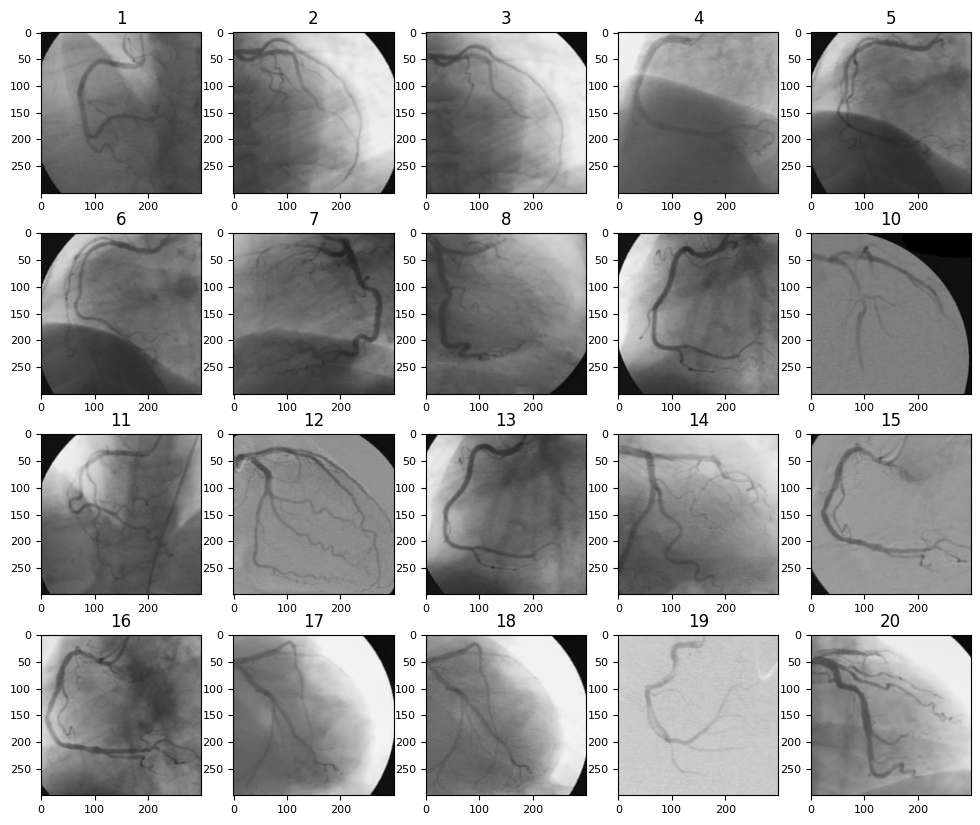

In [7]:
plot_elements_in_matrix(pgm_list)

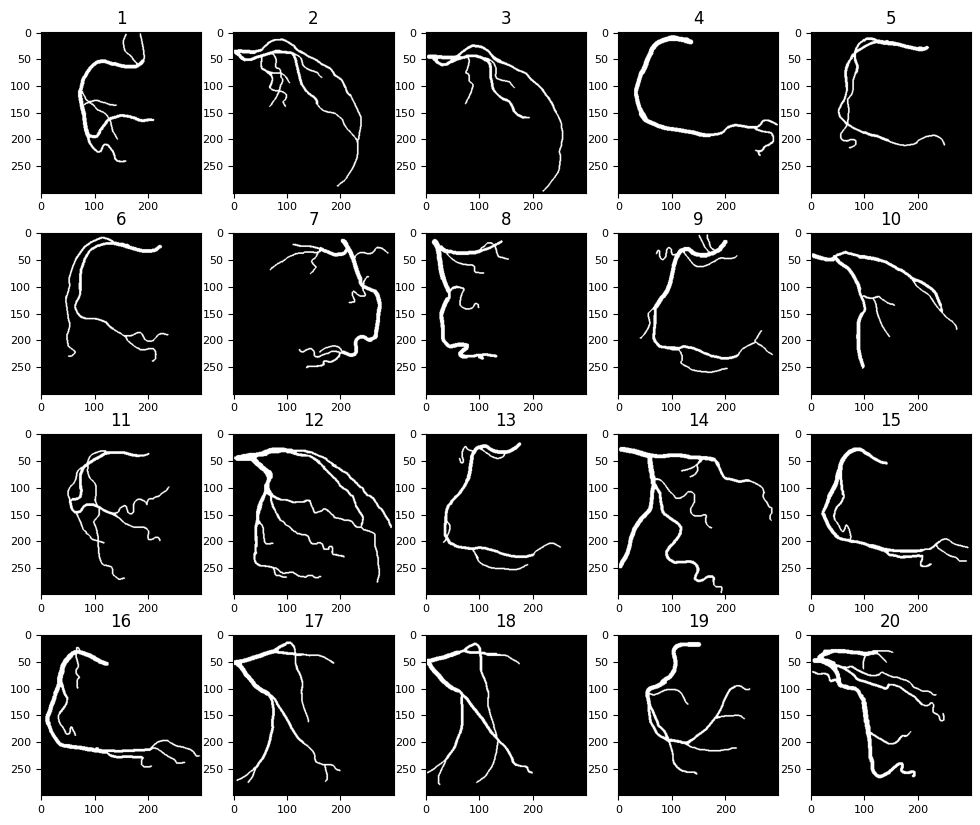

In [8]:
plot_elements_in_matrix(pgm_gt_list)

In [9]:
def filter_large_black_regions(image):
    min_area = 25*25
    _, binary_image = cv2.threshold(image, 25, 255, cv2.THRESH_BINARY)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    filtered_image = np.copy(image)
    for label in range(1, num_labels):
        if stats[label, cv2.CC_STAT_AREA] >= min_area:
            filtered_image[labels == label] = 255
    _, final_image = cv2.threshold(filtered_image, 200, 255, cv2.THRESH_BINARY)
    return final_image

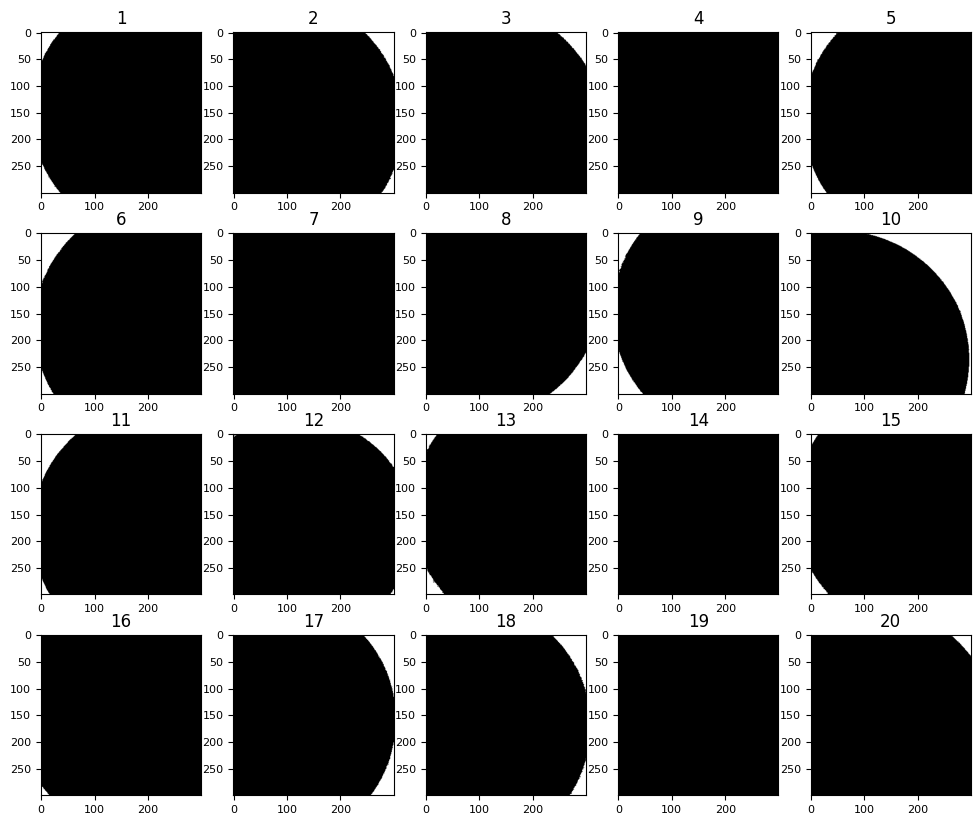

In [10]:
pgm_mask = []
for image in pgm_list:
    mask = filter_large_black_regions(image)
    mask = 255 - mask
    pgm_mask.append(np.uint8(mask))
plot_elements_in_matrix(pgm_mask)

In [11]:
kernel_size = (5,5)
for i, image in enumerate(pgm_list):
    mask = pgm_mask[i]
    blurred_image = cv2.GaussianBlur(image, kernel_size, 0)
    median_color = np.median(blurred_image)
    image[mask == 255] = median_color

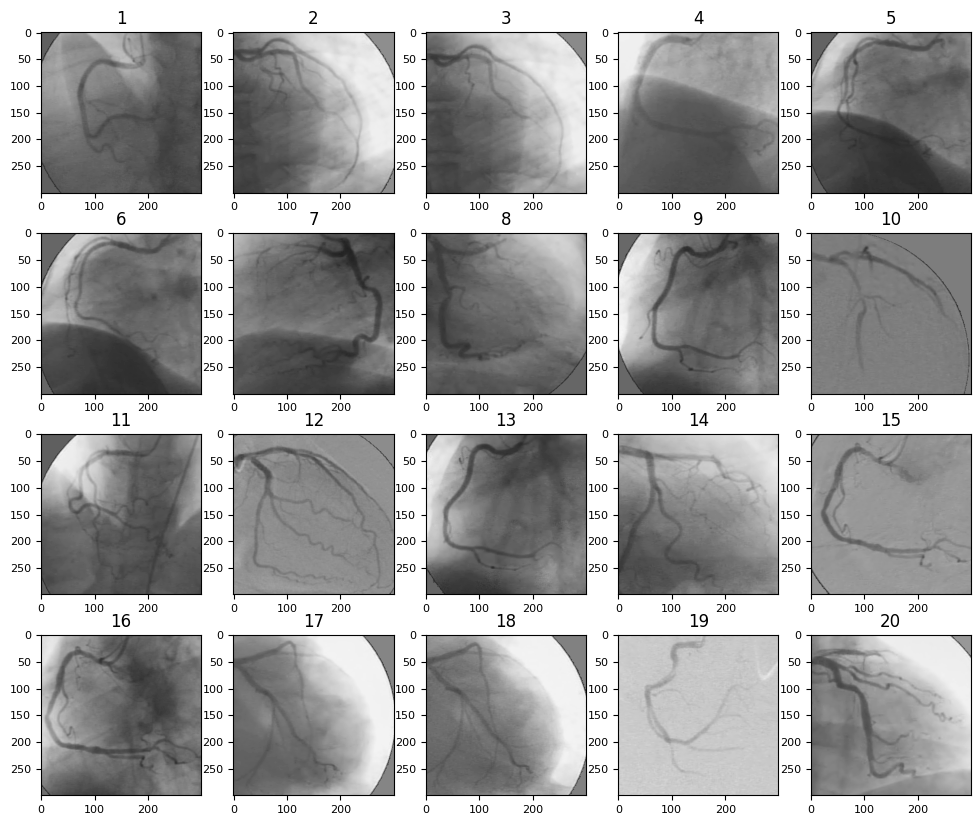

In [12]:
plot_elements_in_matrix(pgm_list)

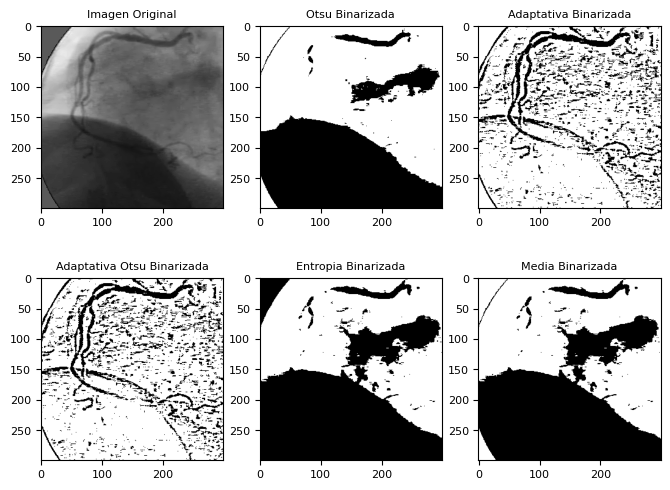

In [13]:
imagen = pgm_list[4]
# Binarizar la imagen usando el método de Otsu
_, otsu_binarizada = cv2.threshold(imagen, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Binarizada por metodo adaptativo
adaptativa_binarizada = cv2.adaptiveThreshold(imagen, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
# Binarización luego del método adaptativo
_, adaptativa_otsu_binarizada = cv2.threshold(adaptativa_binarizada, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

def entropy(image):
    hist = cv2.calcHist([image],[0],None,[256],[0,256])
    hist = hist.ravel() / hist.sum()
    logs = np.log2(hist + np.finfo(float).eps)
    return -1 * (hist * logs).sum()

def entropy_threshold(image):
    max_entropy = -1
    max_threshold = -1
    for t in range(1, 255):
        _, binary = cv2.threshold(image, t, 255, cv2.THRESH_BINARY)
        ent = entropy(binary)
        if ent > max_entropy:
            max_entropy = ent
            max_threshold = t
    return max_threshold

threshold = entropy_threshold(imagen)
_, entropia_binarizada = cv2.threshold(imagen, threshold, 255, cv2.THRESH_BINARY)

# Binarización por método de mediana
_, media_binarizada = cv2.threshold(imagen, np.mean(imagen), 255, cv2.THRESH_BINARY)

plt.figure(figsize=(8, 6))
plt.subplot(2, 3, 1).tick_params(axis='both', which='both', labelsize=8)
plt.imshow(imagen, cmap='gray')
plt.title('Imagen Original', fontsize = 8)

plt.subplot(2, 3, 2).tick_params(axis='both', which='both', labelsize=8)
plt.imshow(otsu_binarizada, cmap='gray')
plt.title('Otsu Binarizada', fontsize = 8)

plt.subplot(2, 3, 3).tick_params(axis='both', which='both', labelsize=8)
plt.imshow(adaptativa_binarizada, cmap='gray')
plt.title('Adaptativa Binarizada', fontsize = 8)

plt.subplot(2, 3, 4).tick_params(axis='both', which='both', labelsize=8)
plt.imshow(adaptativa_otsu_binarizada, cmap='gray')
plt.title('Adaptativa Otsu Binarizada', fontsize = 8)

plt.subplot(2, 3, 5).tick_params(axis='both', which='both', labelsize=8)
plt.imshow(entropia_binarizada, cmap='gray')
plt.title('Entropia Binarizada', fontsize = 8)

plt.subplot(2, 3, 6).tick_params(axis='both', which='both', labelsize=8)
plt.imshow(media_binarizada, cmap='gray')
plt.title('Media Binarizada', fontsize = 8)

plt.show()

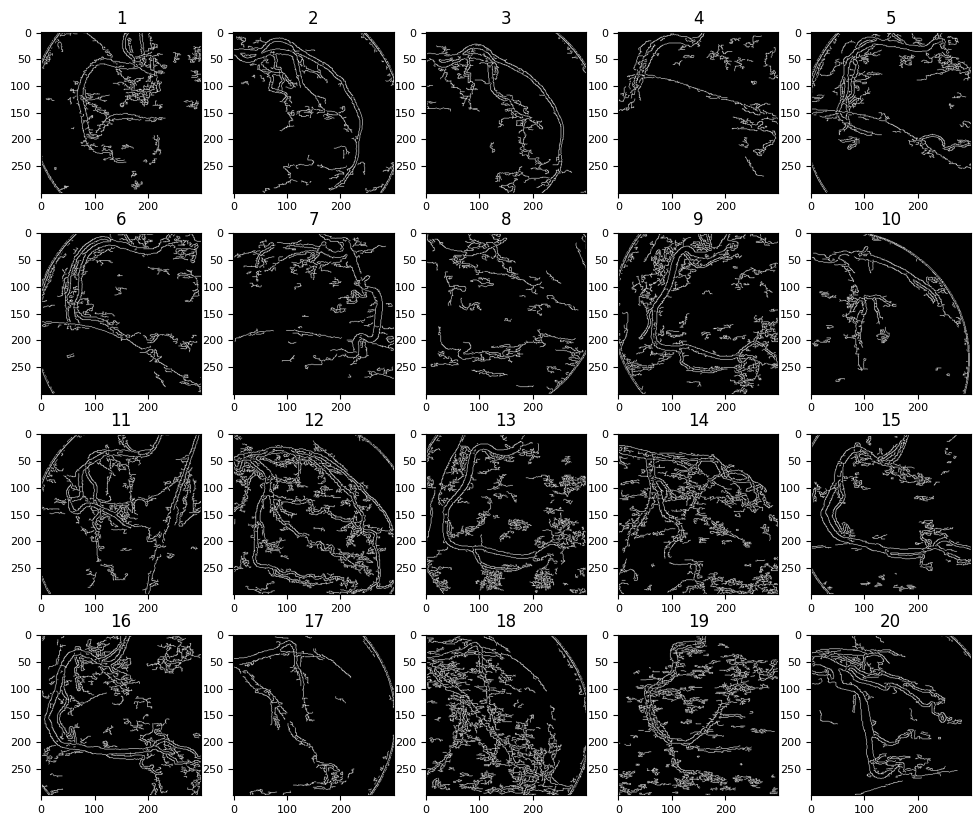

In [14]:
canny_mask = []
for image in pgm_list:
    filter = cv2.Canny(image, 17, 60)
    canny_mask.append(filter)
plot_elements_in_matrix(canny_mask)

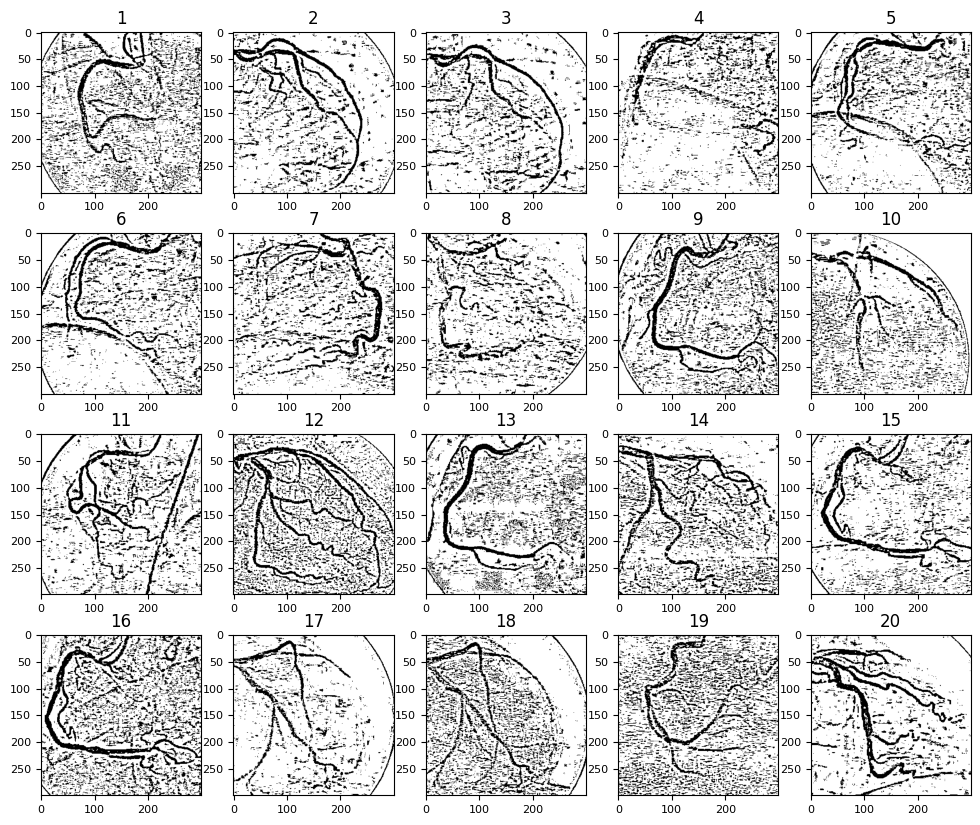

In [15]:
adaptative_mask = []
for image in pgm_list:
    filter = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
    adaptative_mask.append(filter)
plot_elements_in_matrix(adaptative_mask)

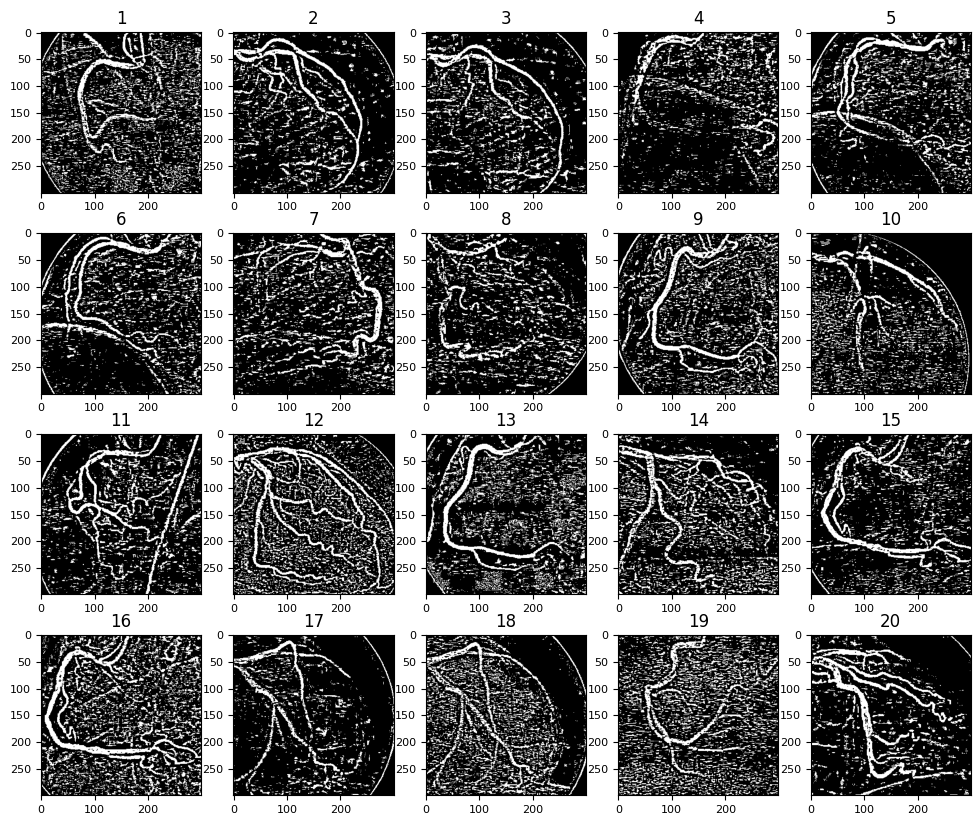

In [16]:
adaptative_mask_inv = []
for image in adaptative_mask:
    inverted_image = 255 - image
    adaptative_mask_inv.append(inverted_image)
plot_elements_in_matrix(adaptative_mask_inv)

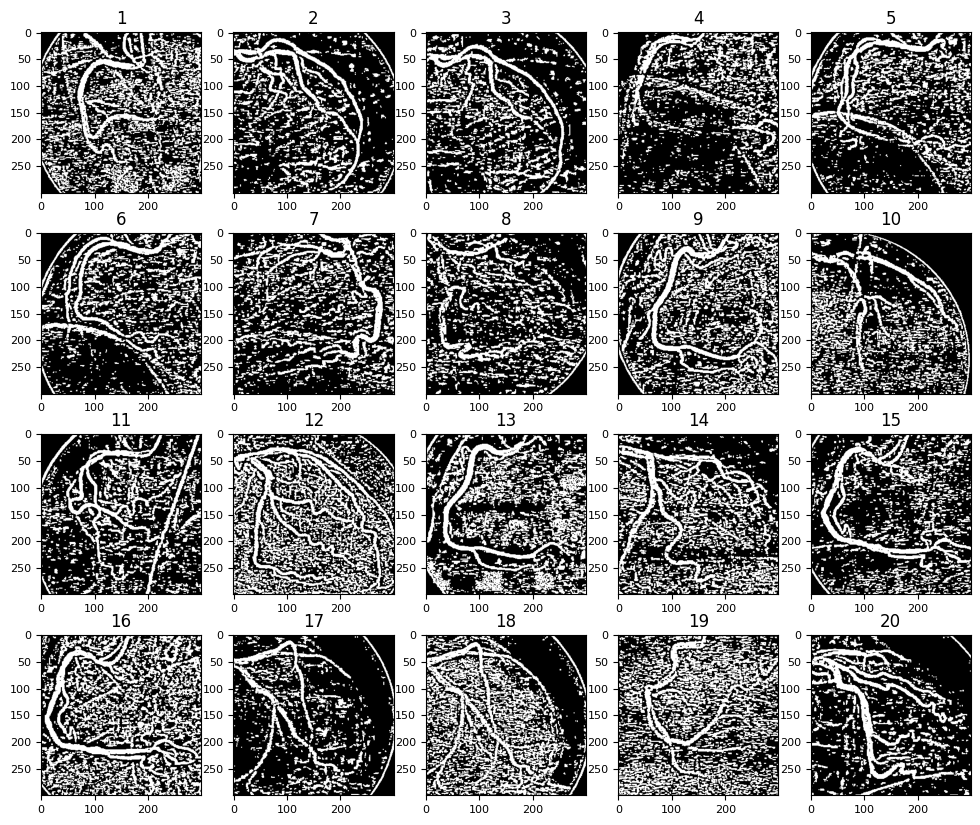

In [17]:
adaptive_closing_list = []
for image in adaptative_mask_inv:
    kernel = np.ones((1, 1), np.uint8)
    closing_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=10)
    kernel2 = np.ones((2, 2), np.uint8)
    dilate_image = cv2.dilate(closing_image, kernel2, iterations =1)
    adaptive_closing_list.append(dilate_image)
plot_elements_in_matrix(adaptive_closing_list)

In [18]:
def remove_lumps(image):
    # Apply non-local means denoising
    adaptativa_binarizada = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5)
    denoised_image = cv2.fastNlMeansDenoising(adaptativa_binarizada, None, h=20, templateWindowSize=3, searchWindowSize=2)
    return denoised_image

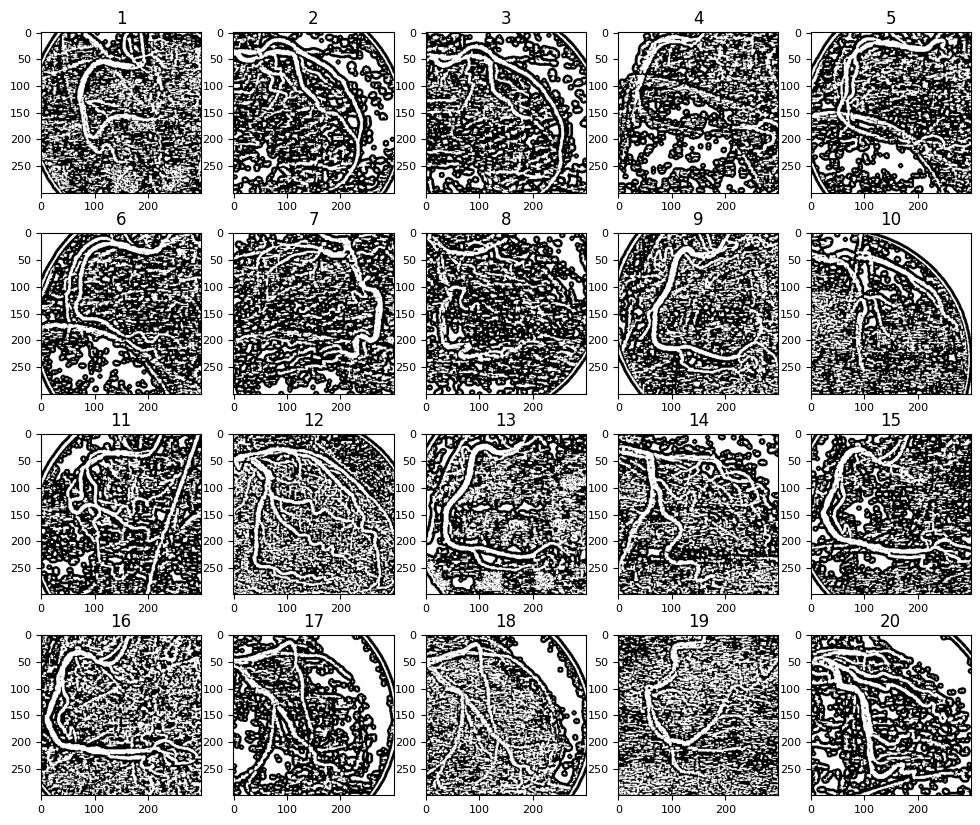

In [19]:
deonoised_list = []
for image in adaptive_closing_list:
    filter = remove_lumps(image)
    deonoised_list.append(filter)
plot_elements_in_matrix(deonoised_list)

In [20]:
def canny_binarization(image):
    # Apply Canny edge detection
    edges = cv2.Canny(image, 17, 90) # 17,60
    
    # Apply adaptive thresholding
    binarized_image = cv2.adaptiveThreshold(edges, 50, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    
    # Apply closing
    kernel = np.ones((1, 1), np.uint8)
    closing_image = cv2.morphologyEx(binarized_image, cv2.MORPH_CLOSE, kernel)
    
    # Apply second thresholding
    closing_image[closing_image > 200] = 0
    closing_image[closing_image == 50] = 255
    close_image2 = closing_image
    
    # Define kernel for dilation
    #kernel2 = np.array(((0, 0, 0),
    #                    (1, 1, 1),
    #                    (0, 0, 0)), np.uint8)
    #close_image = cv2.erode(closing_image, kernel2, iterations=1)
    #kernel3 = np.array(((0, 1, 0),
    #                    (0, 1, 0),
    #                    (0, 1, 0)), np.uint8)
    #close_image2 = cv2.erode(close_image, kernel3, iterations=1)
    return close_image2

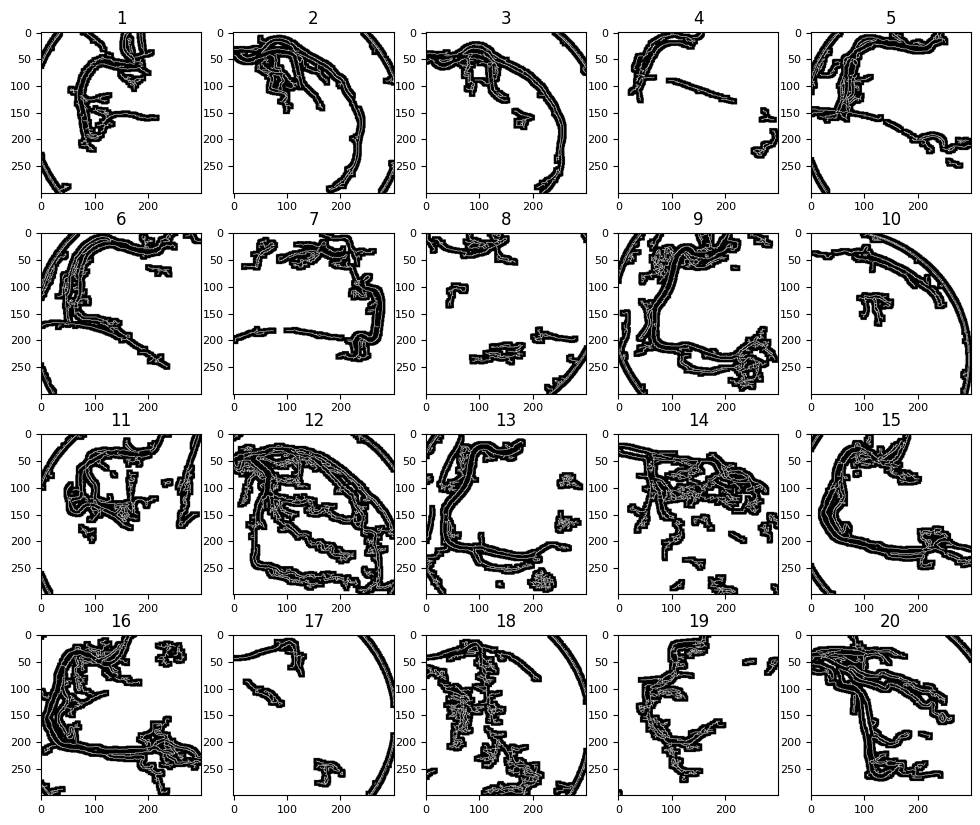

In [21]:
canny_bin_list = []
for image in pgm_list:
    filter = canny_binarization(image)
    canny_bin_list.append(filter)
plot_elements_in_matrix(canny_bin_list)

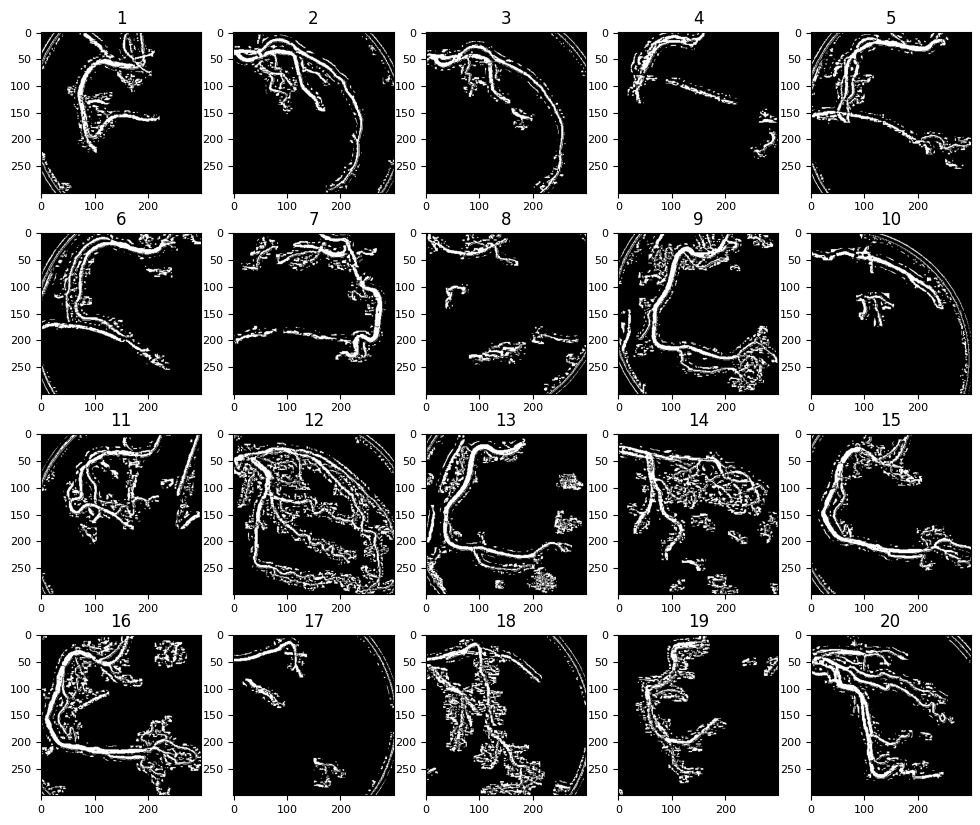

In [22]:
mask_clear_list = []
for i, (denoised_image, canny_bin_image) in enumerate(zip(deonoised_list, canny_bin_list)):
    # Create an empty image for the cleaned mask
    clean = denoised_image
    
    # Iterate through each pixel in the canny bin image
    for x in range(canny_bin_image.shape[0]):
        for y in range(canny_bin_image.shape[1]):
            # If the pixel in the canny bin image is 255, set the corresponding pixel in the denoised image to 0
            if canny_bin_image[x, y] == 255:
                clean[x,y] = 0
    # Append the cleaned image to the mask_clear_list
    mask_clear_list.append(clean)
plot_elements_in_matrix(mask_clear_list)

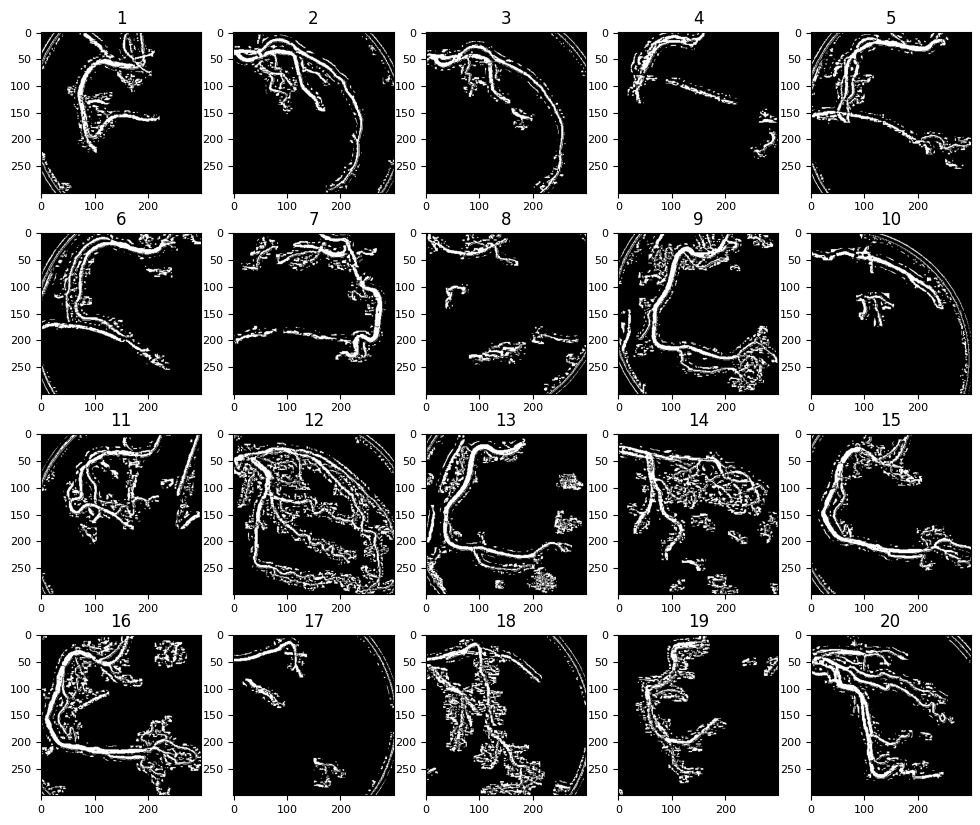

In [23]:
final_closing_list = []
for image in mask_clear_list:
    kernel = np.ones((1, 1), np.uint8)
    closing_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    dilation = cv2.dilate(closing_image, kernel, iterations =1)
    final_closing_list.append(dilation)
plot_elements_in_matrix(final_closing_list)

In [24]:
def comparacion_algoritmo(original_images, groundtruth_images, final_images, i):    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    axes[0].imshow(original_images[i-1], cmap='gray')
    axes[0].set_title(f'Original {i}')
    axes[0].axis('off')
    axes[1].imshow(groundtruth_images[i-1], cmap='gray')
    axes[1].set_title(f'Groundtruth {i}')
    axes[1].axis('off')
    axes[2].imshow(final_images[i-1], cmap='gray')
    axes[2].set_title(f'Intento del Algoritmo {i}')
    axes[2].axis('off')
    plt.tight_layout()
    plt.show()

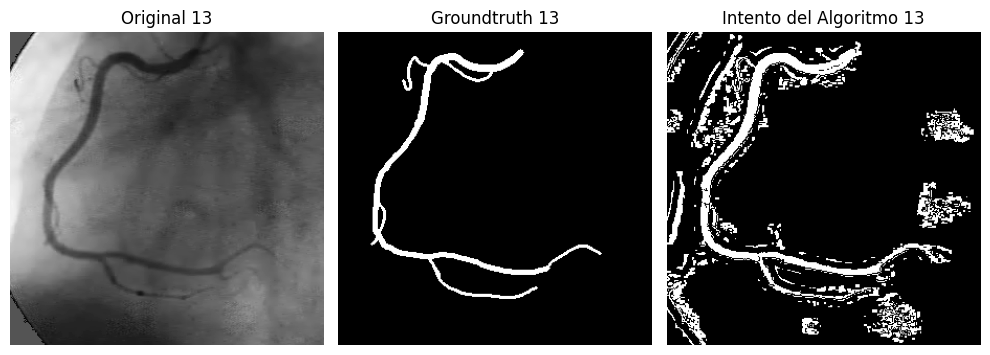

In [25]:
comparacion_algoritmo(pgm_list, pgm_gt_list,final_closing_list, 13)

In [26]:
def calculate_metrics(binary_image, image_res):
    binary_image_flat = binary_image.flatten()
    imagenres_flat = image_res.flatten()

    accuracy = accuracy_score(imagenres_flat, binary_image_flat)
    precision = precision_score(imagenres_flat, binary_image_flat, pos_label=255)
    recall = recall_score(imagenres_flat, binary_image_flat, pos_label=255)
    f1 = f1_score(imagenres_flat, binary_image_flat, pos_label=255)

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

In [27]:
metrics_data = []
for idx, (pgm_gt_image, final_image) in enumerate(zip(pgm_gt_list, final_closing_list), start=0):
    metrics = calculate_metrics(pgm_gt_image, final_image)
    metrics_data.append(metrics)
df = pd.DataFrame(metrics_data)
print(df)
column_averages = df.mean()
column_averages_df = pd.DataFrame(column_averages).T.rename(index={0: 'Avg'})
print(column_averages_df)

    Accuracy  Precision    Recall  F1 Score
0   0.938567   0.752711  0.382527  0.507263
1   0.945722   0.840631  0.459056  0.593831
2   0.956200   0.811471  0.486005  0.607917
3   0.943067   0.380438  0.362569  0.371288
4   0.920522   0.684178  0.266643  0.383734
5   0.924367   0.764473  0.293691  0.424355
6   0.925100   0.677878  0.361068  0.471170
7   0.930000   0.327697  0.283536  0.304021
8   0.891678   0.849007  0.300510  0.443899
9   0.938811   0.491388  0.356683  0.413338
10  0.912122   0.653647  0.264888  0.376999
11  0.847444   0.770535  0.312507  0.444669
12  0.902333   0.887430  0.274732  0.419572
13  0.877522   0.591530  0.312464  0.408923
14  0.932156   0.873896  0.410246  0.558368
15  0.887122   0.869495  0.312563  0.459829
16  0.945400   0.369570  0.419678  0.393034
17  0.874122   0.646362  0.236662  0.346467
18  0.926744   0.596500  0.336307  0.430115
19  0.925889   0.821954  0.486830  0.611486
     Accuracy  Precision    Recall  F1 Score
Avg  0.917244    0.68304  0.345